This exercise includes four parts:
1. Gaussian filtering
2. Fourier transform
3. Image derivatives
4. Edge detection

**Important**:
Follow the instructions below when submitting your attempt.
Submissions not following these instructions will not be graded.

1. **Use JupyterLab**. Other notebook-editing software (e.g. VSCode, pycharm) might corrupt the notebook files.
3. **Do not remove, modify or duplicate** any given cells, except those in which you need to fill in your implementation. You can add new cells in order to present additional texts or plots.
4. **Restart the kernel and re-run the whole notebook** once before submission. After this step, the cell id should be incremental from top to bottom, and all plots should be displayed.
5. **Submit only the `.ipynb` files**, do not upload archives (zip, rar, tar, etc.), images or datasets.
6. **Do not change the filenames** of the `.ipynb` files.

In [1]:
import numpy as np
import scipy.signal
from scipy import ndimage
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import imageio

# Gaussian Filtering
In the following, you will implement a method which generates and applies a Gaussian filter for a given variance and number of samples.

In [2]:
# Some convenience functions.

def plot_multiple(images, titles, colormap='gray', max_columns=np.inf, share_axes=True):
    """Plot multiple images as subplots on a grid."""
    assert len(images) == len(titles)
    n_images = len(images)
    n_cols = min(max_columns, n_images)
    n_rows = int(np.ceil(n_images / n_cols))
    fig, axes = plt.subplots(
        n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4),
        squeeze=False, sharex=share_axes, sharey=share_axes)

    axes = axes.flat
    # Hide subplots without content
    for ax in axes[n_images:]:
        ax.axis('off')
        
    if not isinstance(colormap, (list,tuple)):
        colormaps = [colormap]*n_images
    else:
        colormaps = colormap

    for ax, image, title, cmap in zip(axes, images, titles, colormaps):
        ax.imshow(image, cmap=cmap)
        ax.set_title(title)
        
    fig.tight_layout()

Start by writing a function ``gauss`` which creates a 1D Gaussian from a given vector of integer indices $\mathtt{x = [-w, \ldots, w]}$:
$$
    \mathtt{G[i]} = \frac{1}{\sqrt{2\pi}\sigma}\operatorname{exp}\biggl(-\frac{\mathtt{x[i]}^2}{2\sigma^2}\biggr)
$$
where $\sigma$ is the standard deviation.

Tip: In NumPy the best practice is to use functions on entire arrays at once, instead of iterating over items one by one. This makes the code easier to understand and also faster (since the actual loop is implemented in C under the hood).

In [3]:
# POINTS: 1

def gauss(x, sigma):
    # YOUR CODE HERE
    return np.exp(-x**2/(2*(sigma**2)))/((np.sqrt(2*np.pi))*sigma)
    raise NotImplementedError()

Gauss of 5 is 0.00876415024678427


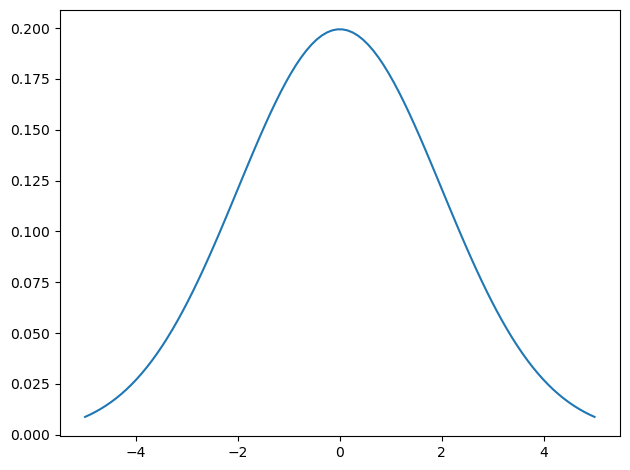

In [4]:
x = np.linspace(-5, 5, 100)
y = gauss(x, sigma=2)
fig, ax = plt.subplots()
ax.plot(x, y)
fig.tight_layout()

print("Gauss of 5 is", gauss(5, sigma=2))

Use the above function to implement a function `gaussian_filter(image, sigma, padding)`, which first generates a Gaussian filter and then applies it to the `image`.
The size of the filter should be $2 \cdot \lceil 3 \sigma \rceil + 1$.
Remember that the Gaussian is separable, *i.e.* that an equivalent 2D result can be obtained through a sequence of two 1D filtering operations.
Do not use any existing implementation for convolution in this part (e.g. `scipy.ndimage.convolve`).
However, you are allowed to use these implementations in the following questions.

You do not have to implement padding, but if you choose to, you can use whichever padding method that is reasonable. The output must have the same dimension with the input.

In [5]:
# POINTS: 5

def gaussian_filter(image, sigma, padding=True):
    # YOUR CODE HERE
    def convolve(x, kernel, padding):
        kernel_r = kernel[::-1]
        x_padded = np.copy(x)
        zeros= np.zeros(shape = padding)
        x_padded = np.concatenate([zeros, x_padded, zeros])

        result = np.zeros(len(x))
        for i in range(0, len(x_padded)-len(kernel_r)+1):
            result[i] = np.sum(x_padded[i:i+kernel_r.shape[0]].dot(kernel_r))                      
        return result


    #Create kernel
    k = int(np.ceil(3*sigma))
    size = 2 * k + 1
    x = np.linspace(-size/2, size/2, size)
    kernel = gauss(x, sigma)
    kernel = kernel/np.sum(kernel)

    #Create a (256, 320, 4) array
    image_result = np.empty_like(image) 

    '''
    #Split the RGBA image
    R_image = image[:, : ,0]
    G_image = image[:, : ,1]
    B_image = image[:, : ,2]
    A_image = image[:, : ,3]'''
    
    #calculate padding
    padding = int((len(kernel)-1)/2)

    for n in range(4):
        for i, row in enumerate(image[:, :, n]):
            image_result[i, :, n] = convolve(row, kernel, padding=padding)

    #Convolve each col
    for n in range(4):
        for i, col in enumerate(image_result[:, :, n].T):
            image_result[:, i, n] = convolve(col, kernel, padding=padding)
    
    #raise NotImplementedError()
    return image_result

Read the image ``graf_small.png`` and apply the filters with ``sigma = 2``, ``4``, and ``8``.
Again, choose the kernel size as $2 \cdot \lceil 3 \sigma\rceil + 1$.
What do you observe?

C:\Users\Haoling Yang\AppData\Local\Temp\ipykernel_18920\862190268.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread('graf_small.png')


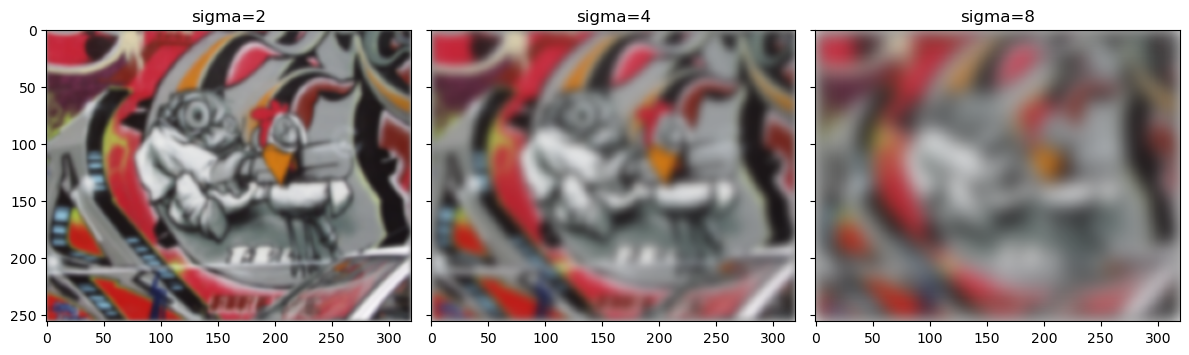

In [6]:
image = imageio.imread('graf_small.png')
sigmas = [2, 4, 8]
blurred_images = [gaussian_filter(image, s) for s in sigmas]
titles = [f'sigma={s}' for s in sigmas]

plot_multiple(blurred_images, titles)

OpenCV has many built-in function for image smoothing.
Check out this page:
https://docs.opencv.org/3.1.0/d4/d13/tutorial_py_filtering.html

Compare the result of ``cv2.GaussianBlur`` with your own implementation by computing the difference image.
Was your implementation correct?

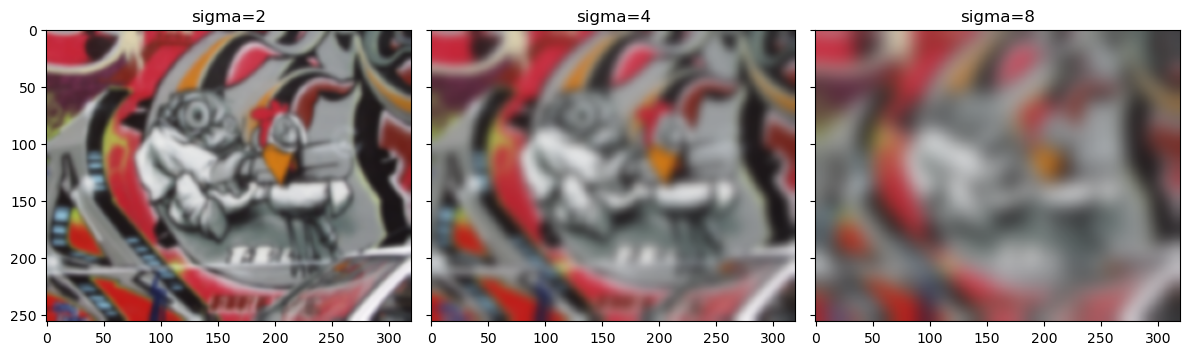

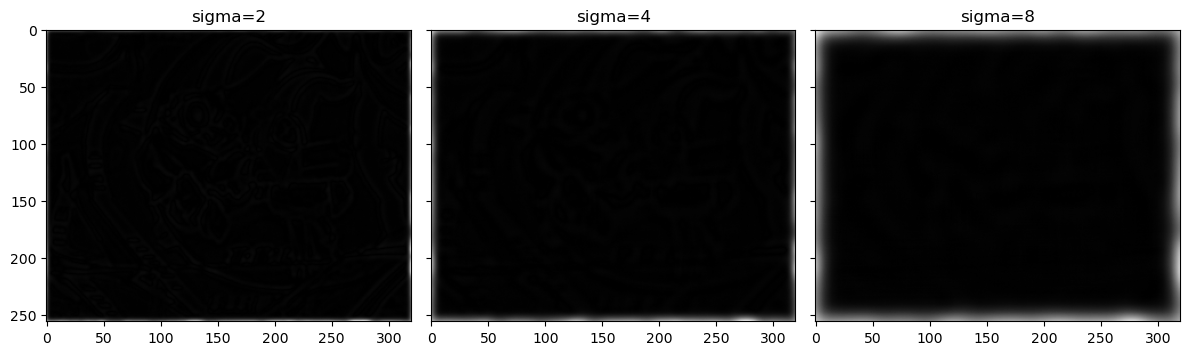

In [7]:
def gauss_cv(image, sigma):
    ks = 2 * int(np.ceil(3 * sigma)) + 1
    return cv2.GaussianBlur(image, (ks, ks), sigma, cv2.BORDER_DEFAULT)

def abs_diff(image1, image2):
    image1 = image1.astype(np.float32)
    image2 = image2.astype(np.float32)
    return np.mean(np.abs(image1-image2), axis=-1)

blurred_images_cv = [gauss_cv(image, s) for s in sigmas]
differences = [abs_diff(x,y) for x, y in zip(blurred_images, blurred_images_cv)]

plot_multiple(blurred_images_cv, titles)
plot_multiple(differences, titles)

# Small differences (around 1-2) can be expected because of rounding
# Mouse over the difference image and see the value in the corner in square brackets

# Fourier Transform

In this part, we look at the effect of filtering in Fourier space.
This gives us a different way of looking at images and yields deeper insights to what is going on when we apply a filter or downsample an image.

In [8]:
# Some Convenience Functions.

def imread_gray(filename):
    """Read grayscale image from our data directory."""
    return cv2.imread(filename, cv2.IMREAD_GRAYSCALE).astype(np.float32)

def convolve_with_two(image, kernel1, kernel2):
    """Apply two filters, one after the other."""
    image = ndimage.convolve(image, kernel1, mode='wrap')
    image = ndimage.convolve(image, kernel2, mode='wrap')
    return image

def fourier_spectrum(im):
    normalized_im = im / np.sum(im)
    f = np.fft.fft2(normalized_im)
    return np.fft.fftshift(f)

def log_magnitude_spectrum(im):
    return np.log(np.abs(fourier_spectrum(im))+1e-8)

def plot_with_spectra(images, titles):
    """Plots a list of images in the first column and the logarithm of their
    magnitude spectrum in the second column."""
    
    assert len(images) == len(titles)
    n_cols = 2
    n_rows = len(images)
    fig, axes = plt.subplots(
        n_rows, 2, figsize=(n_cols * 4, n_rows * 4),
        squeeze=False)

    spectra = [log_magnitude_spectrum(im) for im in images]

    lower = min(np.percentile(s, 0.1) for s in spectra)
    upper = min(np.percentile(s, 99.999) for s in spectra)
    normalizer = mpl.colors.Normalize(vmin=lower, vmax=upper)
    
    for ax, image, spectrum, title in zip(axes, images, spectra, titles):
        ax[0].imshow(image, cmap='gray')
        ax[0].set_title(title)
        ax[0].set_axis_off()
        c = ax[1].imshow(spectrum, norm=normalizer, cmap='viridis')
        ax[1].set_title('Log magnitude spectrum')
        ax[1].set_axis_off()
        
    fig.tight_layout()
    
def gauss(x, sigma):
    return 1 / np.sqrt(2 * np.pi) / sigma * np.exp(- x**2 / 2 / sigma**2)
    
def generate_pattern():
    x = np.linspace(0, 1, 256, endpoint=False)
    y = np.sin(x**2 * 16 * np.pi)
    return np.outer(y,y)/2+0.5

**Plotting demo:**
This is how you can load example images and plot the logarithm of its magnitude spectrum.
Low frequencies appear near the center and higher frequencies towards the outside.
Greener (lighter) colors mean higher values. The color scale is consistent within the subplots of a single plot, but may differ in different plots.

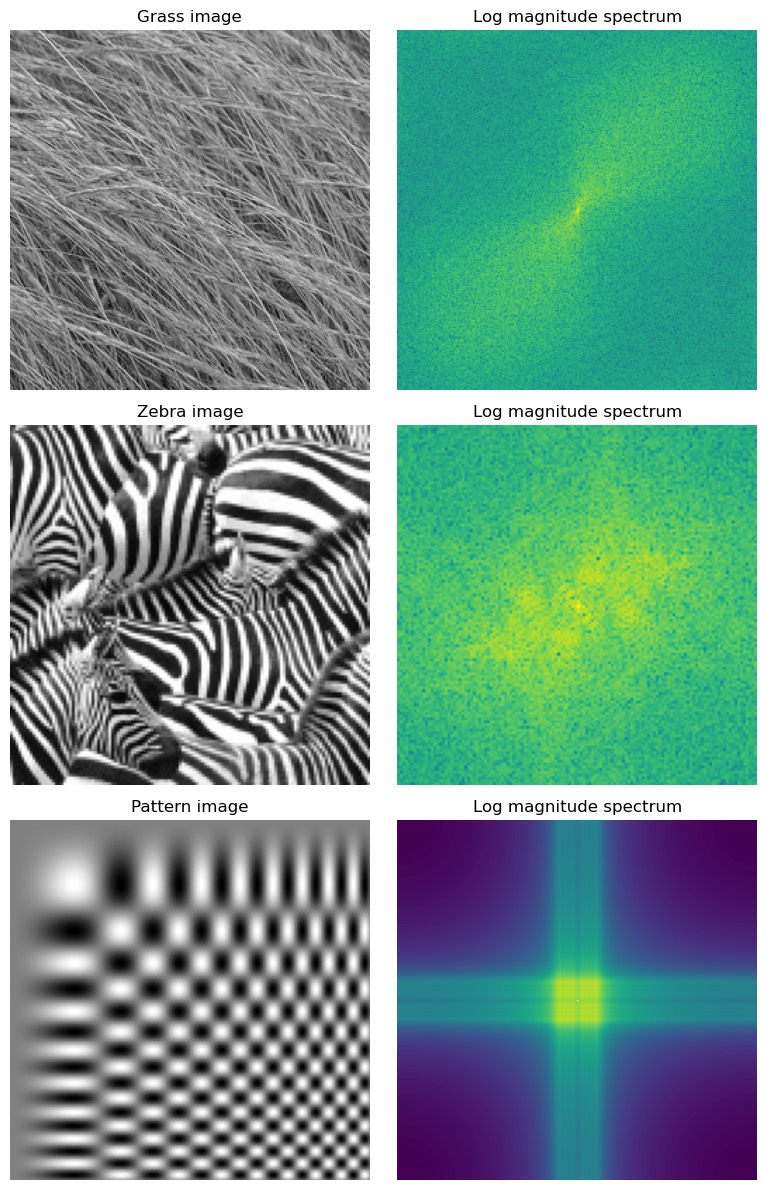

In [9]:
im_grass = imread_gray('grass.jpg')
im_zebras = imread_gray('zebras.jpg')
im_pattern = generate_pattern()
plot_with_spectra([im_grass, im_zebras, im_pattern], ['Grass image', 'Zebra image', 'Pattern image'])

## Blurring

Consider one of the images (`im_grass` is a good choice). Implement `filter_box(image, sigma)` that outputs the box-filtered version of `image`, using `convolve_with_two` (since the box filter is separable). Compute the size of the box filter as `size = int(round(sigma * 12**0.5))` (read [this paper](https://www.peterkovesi.com/papers/FastGaussianSmoothing.pdf) if you are interested in the math behind this formular). 

In [10]:
# POINTS: 2

def filter_box(image, sigma):
    # YOUR CODE HERE
    size = int(round(sigma*12**0.5))
    k1 = np.ones((1,size))/size
    k2 = np.ones((size,1))/size
    return convolve_with_two(image, kernel1=k1, kernel2=k2)
    raise NotImplementedError()

Implement `filter_gauss(image, kernel_factor, sigma)` using `convolve_with_two`. The parameter `kernel_factor` defines the half size of the kernel relative to sigma (our rule of thumb from the lecture was to set this as 3).

In [11]:
# POINTS: 2

def filter_gauss(image, kernel_factor, sigma):
    # YOUR CODE HERE
    k = int(kernel_factor * sigma)
    x = np.linspace(-k, k, 2*k+1)
    k1 = gauss(x, sigma=sigma)
    k1 = k1/np.sum(k1)
    k1 = np.reshape(k1, (1, -1))
    k2 = gauss(x, sigma=sigma)
    k2 = k2/np.sum(k2)
    k2 = np.reshape(k2, (-1, 1))
    return convolve_with_two(image, kernel1=k1, kernel2=k2)
    raise NotImplementedError()

Plot the image and its blurred versions (with the box and the Gauss filter) along with their spectra using `plot_with_spectra()`. Vary the size of the box filter. What do you observe? For the Gaussian, change sigma.  What happens if you increase or decrease the `kernel_factor` compared to our rule-of-thumb value 3?

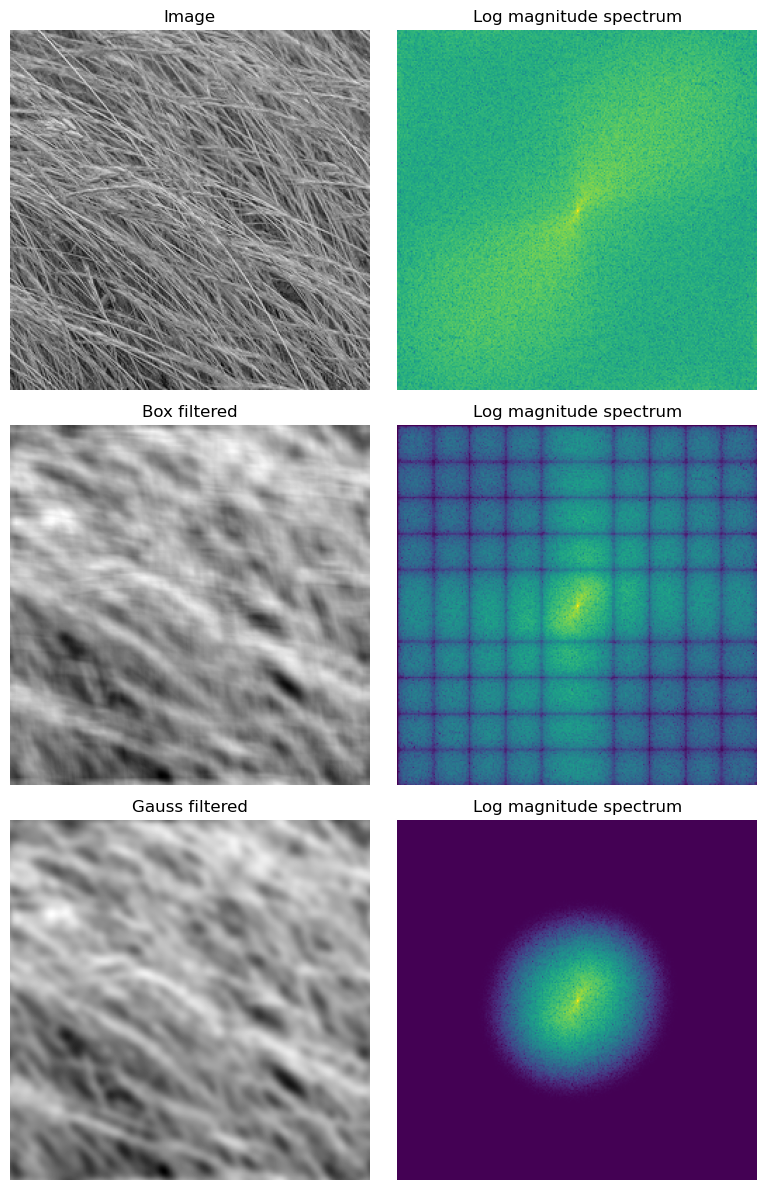

In [12]:
sigma = 3
im = im_grass
gauss_filtered = filter_gauss(im, kernel_factor=6, sigma=sigma)
box_filtered = filter_box(im, sigma=sigma)
plot_with_spectra(
    [im, box_filtered, gauss_filtered], 
    ['Image', 'Box filtered', 'Gauss filtered'])

## Sampling and aliasing

Implement a function `sample_with_gaps(image, period)`, where `period` is an integer and defines the distance between two sampled points in pixels. The output should have the same size as `image` but have zeros everywhere except at the sampled points, where it should be equal to `image`. For example if `period=2` then every second row and every second column of the image should be zero in the output.

In addition, implement `sample_without_gaps(image, period)`, which is like `sample_with_gaps` but the output does not contain gaps (rows and columns of zeros) and therefore the output size is smaller.

Hint: These two functions can easily be realized with Numpy indexing (see this [link](https://numpy.org/doc/stable/user/basics.indexing.html#basics-indexing) if you need an introduction). Do not use for-loop.

In [13]:
# POINTS: 2

def sample_with_gaps(im, period):
    # YOUR CODE HERE
    a = np.zeros_like(im)
    a[::period,::period]=im[::period,::period]
    return a
    raise NotImplementedError()


def sample_without_gaps(im, period):
    # YOUR CODE HERE
    return im[::period,::period]
    raise NotImplementedError()

Sample the `im_zebras` image with a period of 2 pixels and plot the original and sampled images along with their spectra. 
What effect do you see in the resulting magnitude spectrum, when sampling with or without gaps?

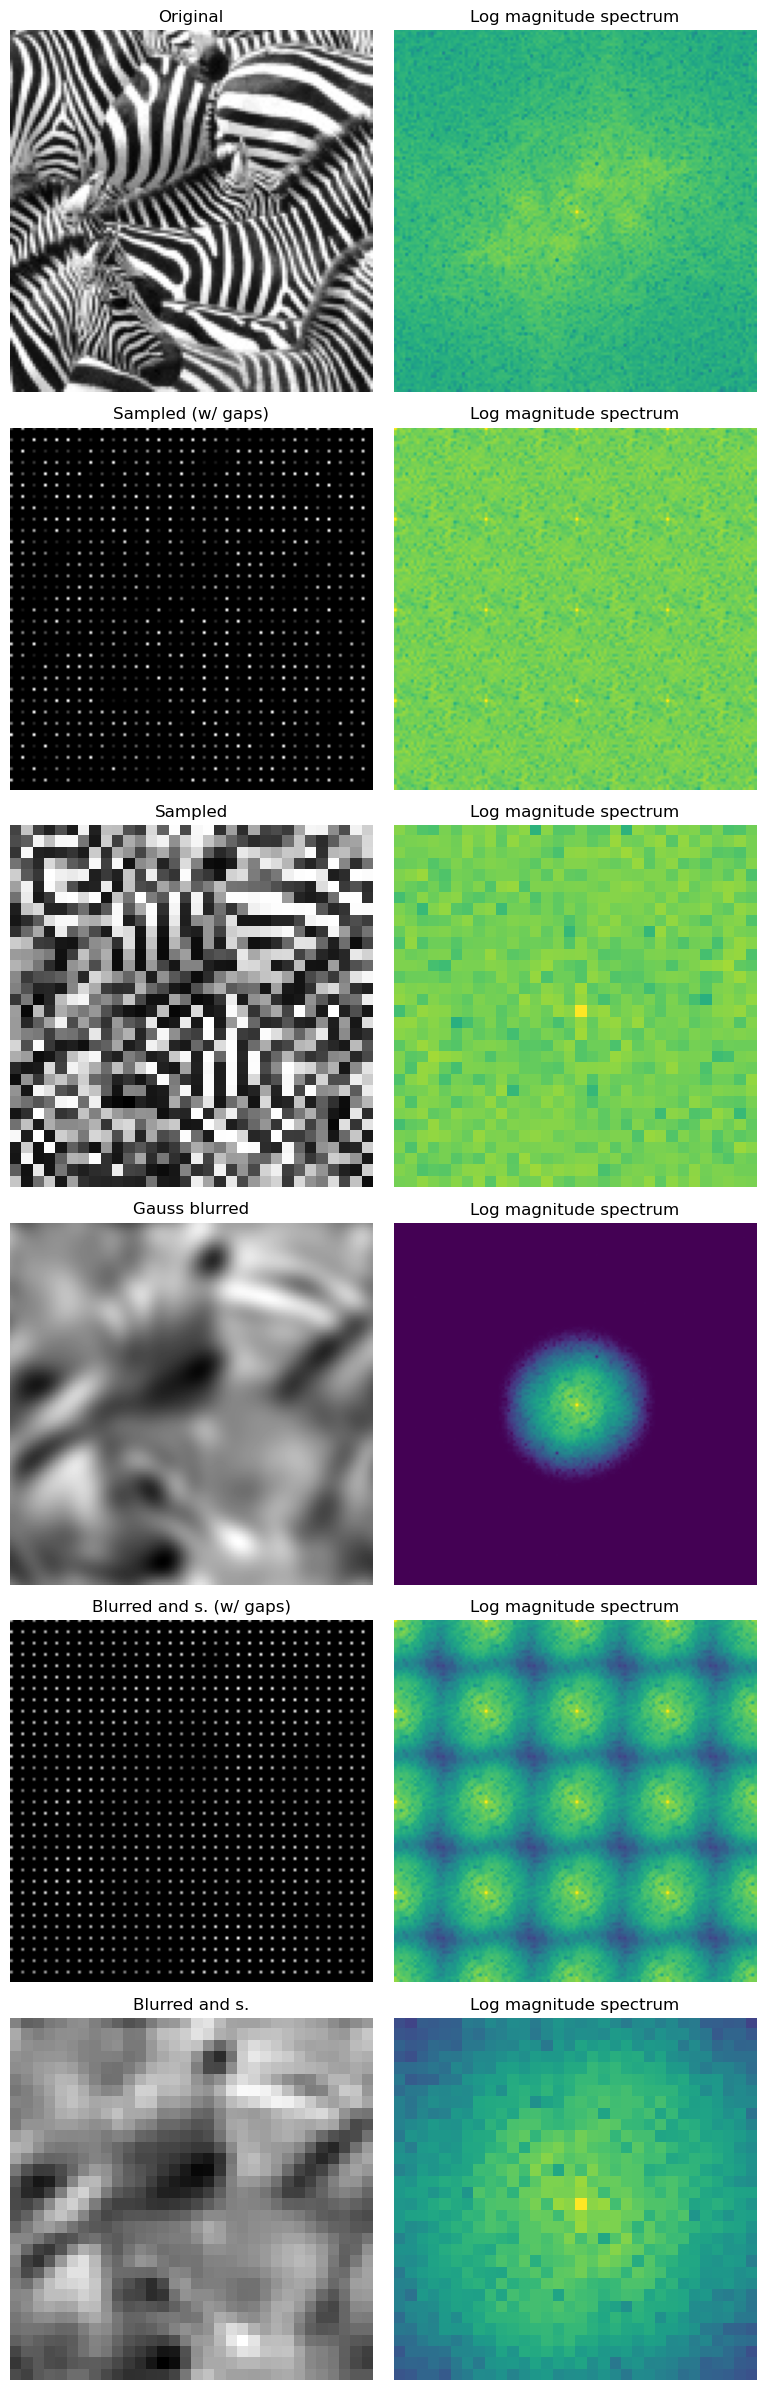

In [14]:
N=4
im = im_zebras
sampled_gaps = sample_with_gaps(im, N)
sampled = sample_without_gaps(im, N)

blurred = filter_gauss(im, kernel_factor=6, sigma=4)
blurred_and_sampled_gaps = sample_with_gaps(blurred, N)
blurred_and_sampled = sample_without_gaps(blurred, N)

plot_with_spectra(
    [im, sampled_gaps, sampled, blurred, blurred_and_sampled_gaps, blurred_and_sampled], 
    ['Original', 'Sampled (w/ gaps)', 'Sampled', 'Gauss blurred', 'Blurred and s. (w/ gaps)', 'Blurred and s.'])

Consider the image `im_pattern` and sample it with a period of 4, 8 and 16 and plot the resulting spectra. What happens as you increase the sampling period?
Now look at what happens when **Gaussian blurring** is applied before sampling, with different sigma values. Approximately what sigma do you need for avoiding artifacts when `period=16`?

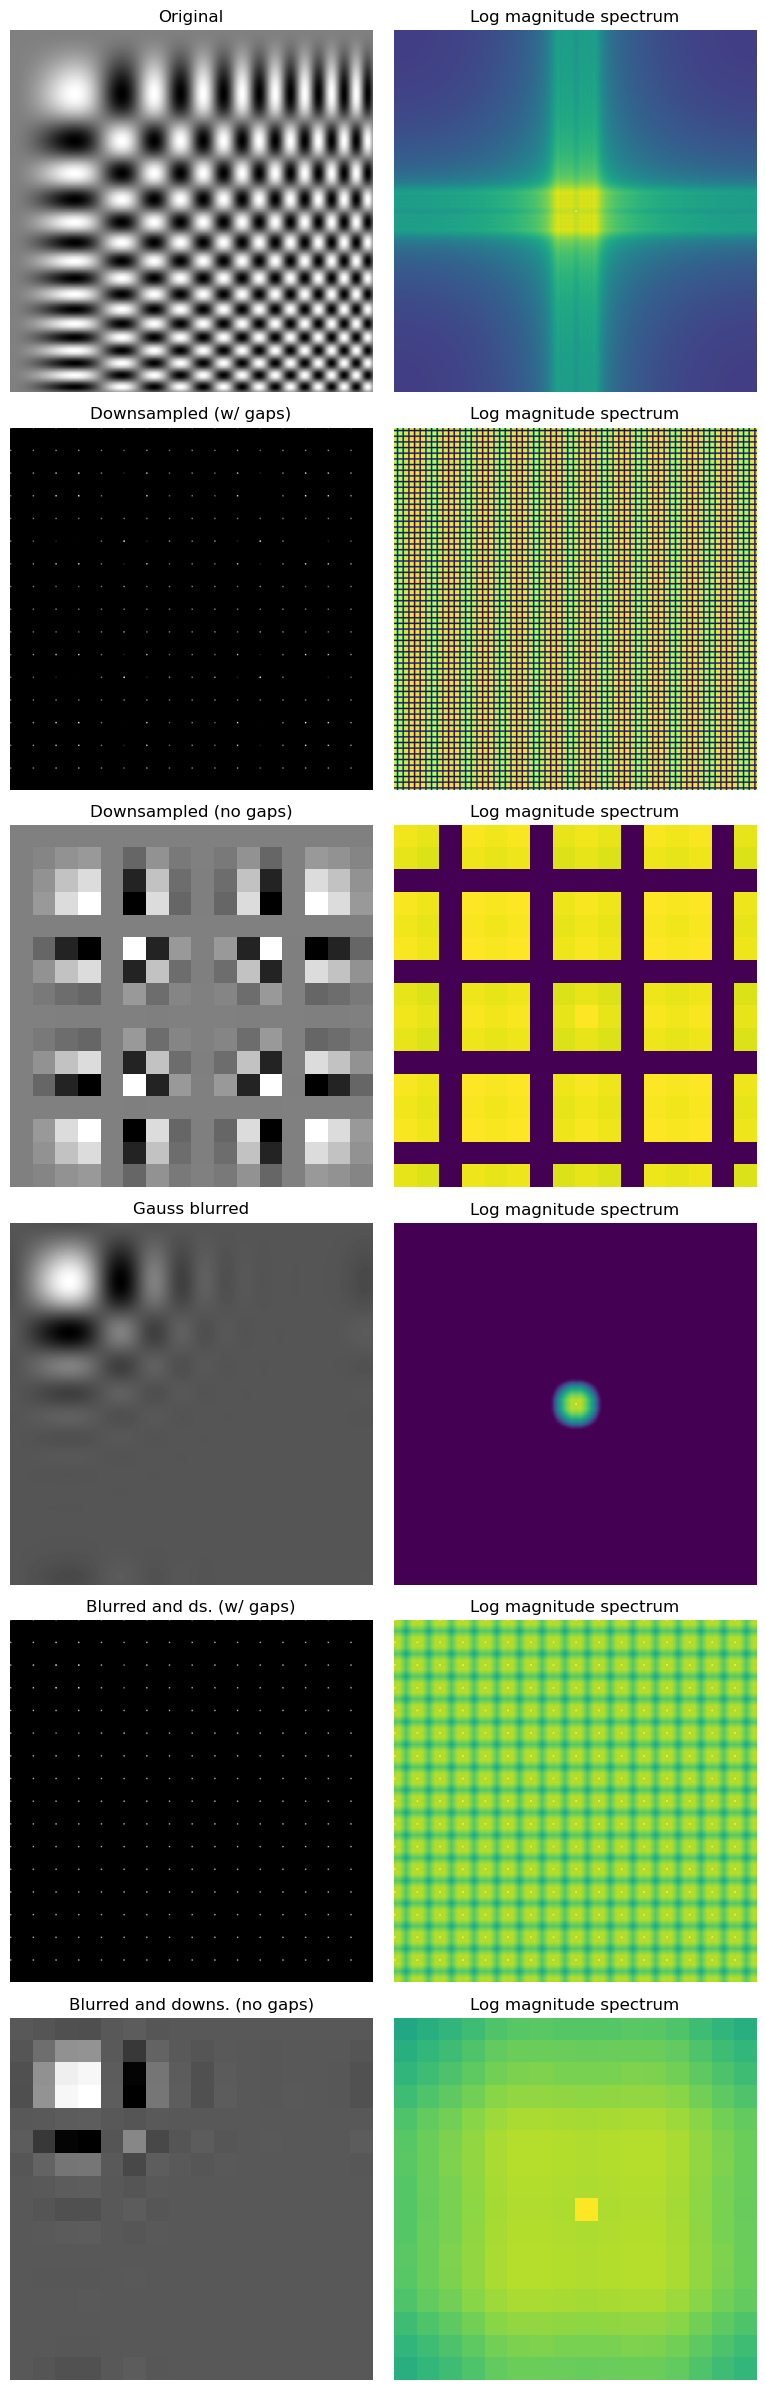

In [15]:
N=16
image = im_pattern
downsampled_gaps = sample_with_gaps(im_pattern, N)
downsampled = sample_without_gaps(im_pattern, N)

blurred = filter_gauss(image, kernel_factor=6, sigma=12)
blurred_and_downsampled_gaps = sample_with_gaps(blurred, N)
blurred_and_downsampled = sample_without_gaps(blurred, N)

plot_with_spectra(
    [im_pattern, downsampled_gaps, downsampled, blurred, blurred_and_downsampled_gaps, blurred_and_downsampled], 
    ['Original', 'Downsampled (w/ gaps)', 'Downsampled (no gaps)', 'Gauss blurred', 'Blurred and ds. (w/ gaps)', 'Blurred and downs. (no gaps)'])

# Image Derivatives
This task introduces image derivative operators.

In [16]:
# Some Convenience Functions.

def convolve_with_two(image, kernel1, kernel2):
    """Apply two filters, one after the other."""
    image = ndimage.convolve(image, kernel1)
    image = ndimage.convolve(image, kernel2)   
    return image

def imread_gray(filename):
    """Read grayscale image."""
    return cv2.imread(filename, cv2.IMREAD_GRAYSCALE).astype(np.float32)

def plot_multiple(images, titles, colormap='gray', max_columns=np.inf, share_axes=True):
    """Plot multiple images as subplots on a grid."""
    assert len(images) == len(titles)
    n_images = len(images)
    n_cols = min(max_columns, n_images)
    n_rows = int(np.ceil(n_images / n_cols))
    fig, axes = plt.subplots(
        n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4),
        squeeze=False, sharex=share_axes, sharey=share_axes)

    axes = axes.flat
    # Hide subplots without content
    for ax in axes[n_images:]:
        ax.axis('off')
        
    if not isinstance(colormap, (list,tuple)):
        colormaps = [colormap]*n_images
    else:
        colormaps = colormap

    for ax, image, title, cmap in zip(axes, images, titles, colormaps):
        ax.imshow(image, cmap=cmap)
        ax.set_title(title)
        
    fig.tight_layout()
    
def gauss(x, sigma):
    return 1.0 / np.sqrt(2.0 * np.pi) / sigma * np.exp(- x**2 / 2.0 / sigma**2)

Implement a function for creating a Gaussian derivative filter in 1D according to the following equation
\begin{eqnarray}
    \frac{d}{dx} G &=& \frac{d}{dx} \frac{1}{\sqrt{2\pi}\sigma} \operatorname{exp}\biggl(-\frac{x^2}{2\sigma^2}\biggr) \\
			       &=& -\frac{1}{\sqrt{2\pi}\sigma^3}x \operatorname{exp}\biggl(-\frac{x^2}{2\sigma^2}\biggr)
\end{eqnarray}
Your function should take a vector of integer values $x$ and the standard deviation ``sigma`` as arguments.

In [17]:
# POINTS: 1

def gaussdx(x, sigma):
    # YOUR CODE HERE
    #np.exp(-x**2/(2*(sigma**2)))/((np.sqrt(2*np.pi))*sigma) gauss
    return -x * np.exp(-x**2/(2 * sigma**2)) / ((np.sqrt(2*np.pi)) * sigma**3)
    raise NotImplementedError()

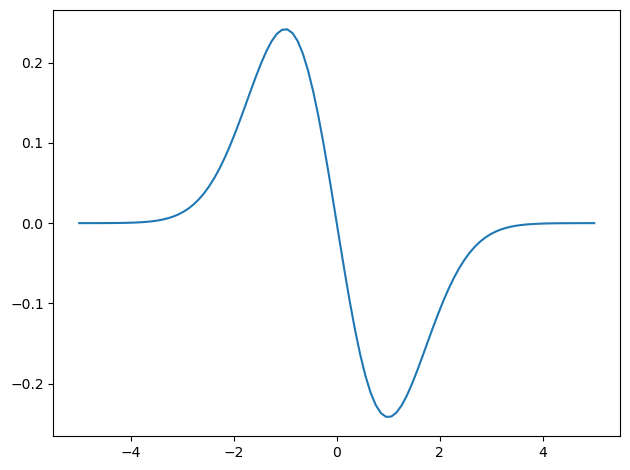

In [18]:
x = np.linspace(-5, 5, 100)
y = gaussdx(x, sigma=1.0)
fig, ax = plt.subplots()
ax.plot(x, y)
fig.tight_layout()

The effect of a filter can be studied by observing its so-called *impulse response*.
For this, create a test image in which only the central pixel has a non-zero value (called an *impulse*).

In [19]:
# POINTS: 1

def make_impulse_image(size=25):
    # YOUR CODE HERE
    center = size//2
    impulse = np.ones((size, size))
    impulse[center, center] = 255
    return impulse
    raise NotImplementedError()

What happens when you apply the following filter combinations on the impulse image?

- first ``gaussian``, then ``gaussian^T``.
- first ``gaussian``, then ``derivative^T``.
- first ``derivative``, then ``gaussian^T``.
- first ``gaussian^T``, then ``derivative``.
- first ``derivative^T``, then ``gaussian``.

Display the result images with the `plot_multiple` function. Describe your result.

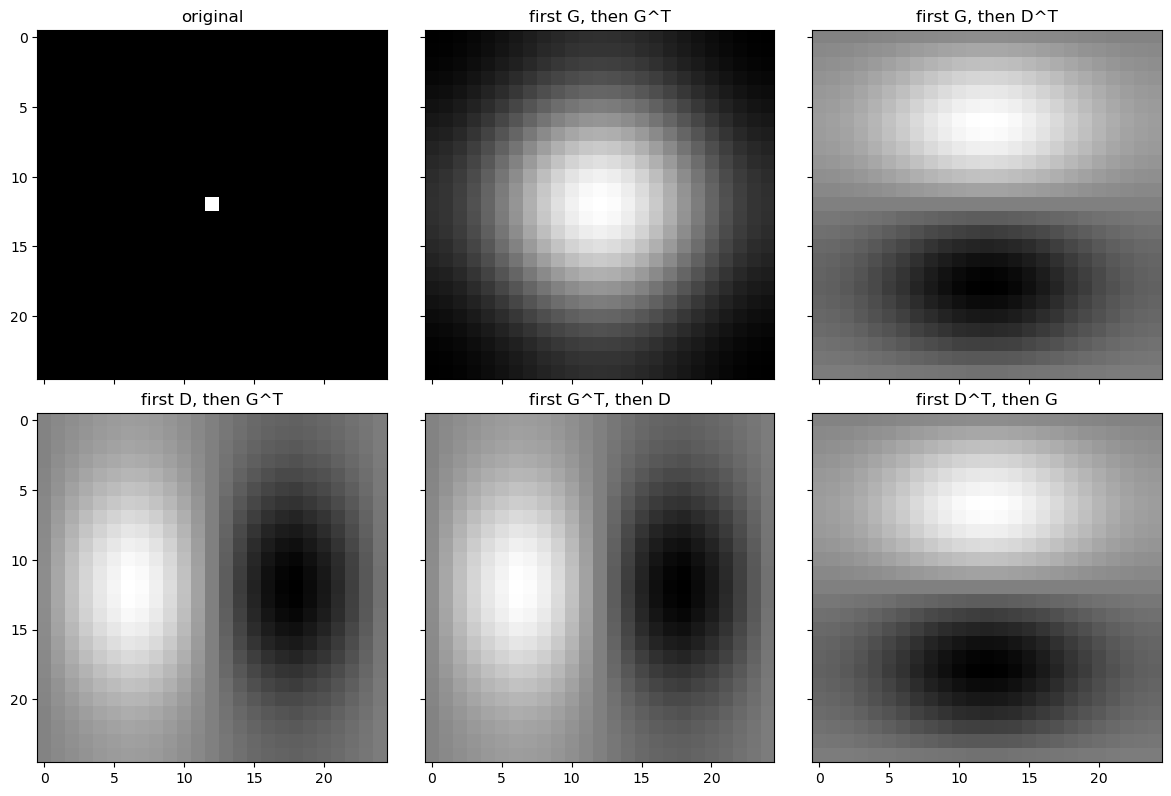

In [20]:
# create kernels
sigma = 6.0
kernel_radius = int(3.0 * sigma)
x = np.arange(-kernel_radius, kernel_radius + 1)[np.newaxis]
G = gauss(x, sigma)
D = gaussdx(x, sigma)

impulse = make_impulse_image()
images = [
    impulse,
    convolve_with_two(impulse, G, G.T),
    convolve_with_two(impulse, G, D.T),
    convolve_with_two(impulse, D, G.T),
    convolve_with_two(impulse, G.T, D),
    convolve_with_two(impulse, D.T, G)]

titles = [
    'original',
    'first G, then G^T',
    'first G, then D^T',
    'first D, then G^T',
    'first G^T, then D',
    'first D^T, then G']

plot_multiple(images, titles, max_columns=3)

Create a new function ``gaussderiv`` using the functions ``gauss`` and ``gaussdx`` directly.
The new function should return the 2D Gaussian derivatives of an input image in $x$ and $y$ direction.
Try the function on the given example images.

In [21]:
# POINTS: 2

def gauss_derivs(image, sigma):
    kernel_radius = int(3.0 * sigma)
    # YOUR CODE HERE
    image_dx = np.empty_like(image)
    image_dy = np.empty_like(image)

    x = np.arange(-kernel_radius, kernel_radius + 1)
    y = np.arange(-kernel_radius, kernel_radius + 1)
    
    kernel_x = gaussdx(x, sigma=sigma)*gauss(y, sigma=sigma)[np.newaxis]

    kernel_y = kernel_x.T

    image_dx = ndimage.convolve(image, kernel_x, mode='wrap')
    image_dy = ndimage.convolve(image, kernel_y, mode='wrap')

    return image_dx, image_dy
    raise NotImplementedError()

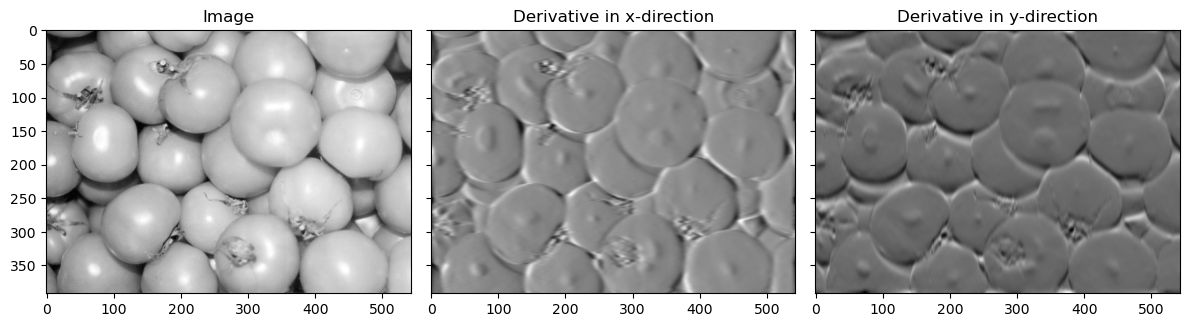

In [22]:
image = imread_gray('tomatoes.png')
grad_dx, grad_dy = gauss_derivs(image, sigma=5.0)
plot_multiple([image, grad_dx, grad_dy], ['Image', 'Derivative in x-direction', 'Derivative in y-direction'])

In a similar manner, create a new function ``gauss_second_derivs`` that returns the 2D second Gaussian derivatives $\frac{d^2}{dx^2}$, $\frac{d^2}{dx dy}$ and $\frac{d^2}{dy^2}$ of an input image.
Try the function on the given example images.

In [23]:
# POINTS: 2

def gauss_second_derivs(image, sigma):
    kernel_radius = int(3.0 * sigma)
    # YOUR CODE HERE
    image_dx = np.empty_like(image)
    image_dy = np.empty_like(image)

    x = np.arange(-kernel_radius, kernel_radius + 1)
    y = np.arange(-kernel_radius, kernel_radius + 1)
    
    kernel_x = gaussdx(x, sigma=sigma) * gauss(y, sigma=sigma)
    kernel_xy = gaussdx(x, sigma=sigma) * gaussdx(y, sigma=sigma)[np.newaxis]
    kernel_xx = kernel_x * (1-(x/sigma)**2)/x
    
    #set behavior for dividing by zero and invalid values to ignore
    np.seterr(divide='ignore', invalid='ignore')
    
    kernel_xx = kernel_xx[np.newaxis]
    kernel_yy = kernel_xx.T

    image_dxy = ndimage.convolve(image, kernel_xy, mode='wrap')
    image_dxx = ndimage.convolve(image, kernel_xx, mode='wrap')
    image_dyy = ndimage.convolve(image, kernel_yy, mode='wrap')

    return image_dxx, image_dxy, image_dyy
    raise NotImplementedError()

C:\Users\Haoling Yang\AppData\Local\Temp\ipykernel_18920\2802651728.py:14: RuntimeWarning: invalid value encountered in true_divide
  kernel_xx = kernel_x * (1-(x/sigma)**2)/x


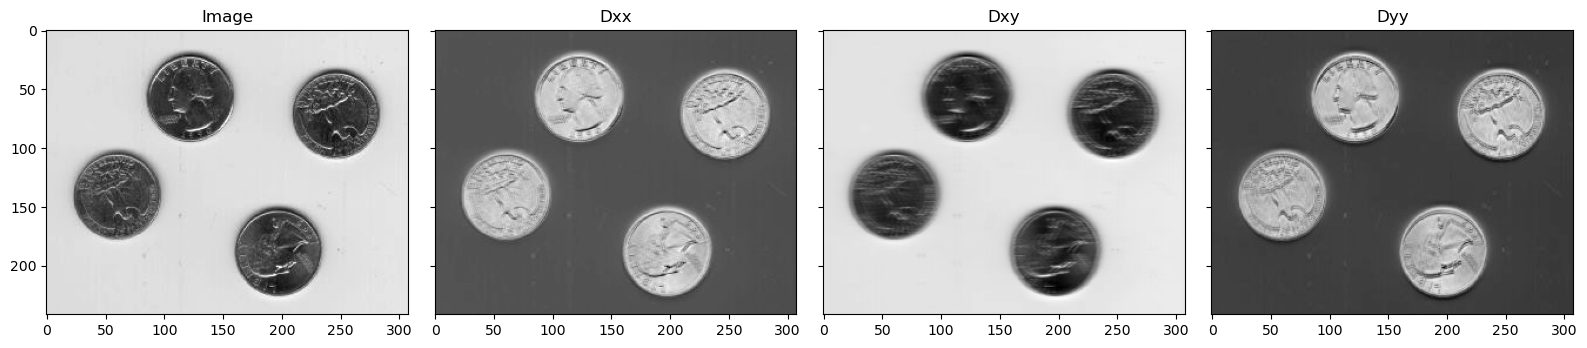

In [24]:
image = imread_gray('coins1.jpg')
grad_dxx, grad_dxy, grad_dyy = gauss_second_derivs(image, sigma=2.0)
plot_multiple([image, grad_dxx, grad_dxy, grad_dyy], ['Image', 'Dxx', 'Dxy','Dyy'])

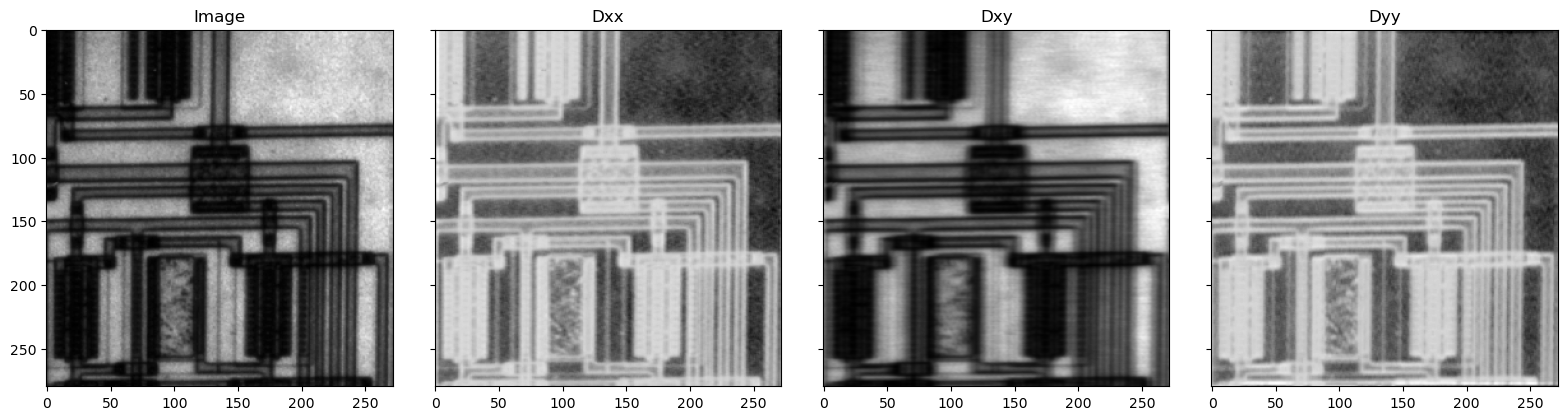

In [25]:
image = imread_gray('circuit.png')
grad_dxx, grad_dxy, grad_dyy = gauss_second_derivs(image, sigma=2.0)
plot_multiple([image, grad_dxx, grad_dxy, grad_dyy], ['Image', 'Dxx', 'Dxy','Dyy'])

Create a new function ``image_gradients_polar`` that returns two images with the magnitude and orientation of the gradient for each pixel of the input image. Try the function on the given example images.

In [26]:
# POINTS: 2

def image_gradients_polar(image, sigma):
    # YOUR CODE HERE
    image_x, image_y = gauss_derivs(image, sigma=sigma)

    magnitude = np.sqrt((image_x)**2 + (image_y)**2)
    #direction = np.arctan(image_y/image_x)
    direction = np.arctan2(image_y, image_x)

    return magnitude, direction
    raise NotImplementedError()

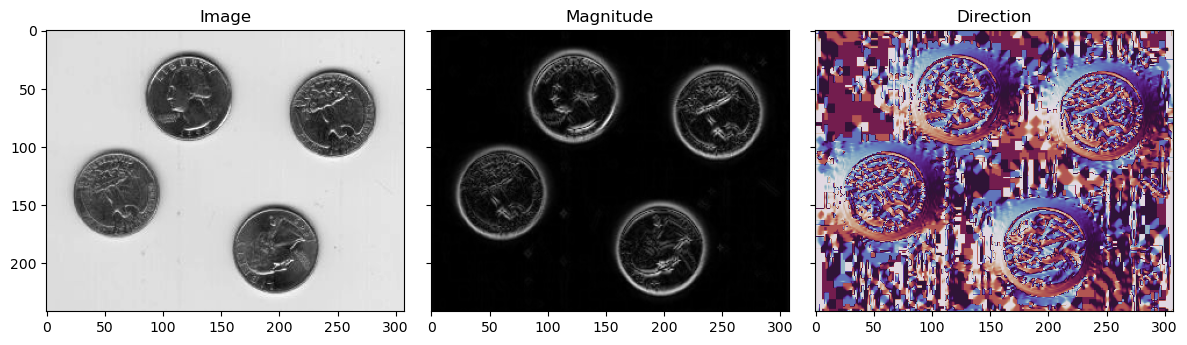

In [27]:
image = imread_gray('coins1.jpg')
grad_mag, grad_dir = image_gradients_polar(image, sigma=2.0)

# Note: the twilight colormap only works since Matplotlib 3.0, use 'gray' in earlier versions.
plot_multiple([image, grad_mag, grad_dir], ['Image', 'Magnitude', 'Direction'], colormap=['gray', 'gray', 'twilight']) 

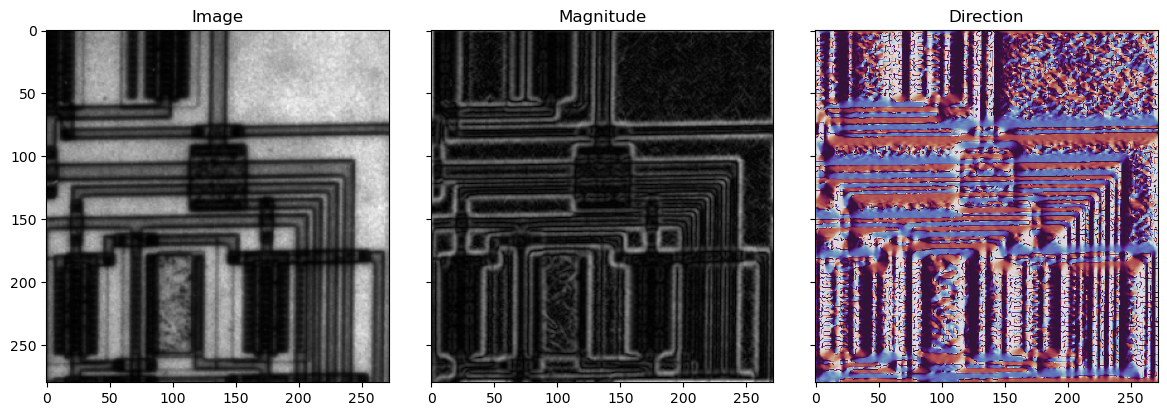

In [28]:
image = imread_gray('circuit.png')
grad_mag, grad_theta = image_gradients_polar(image, sigma=2.0)
plot_multiple([image, grad_mag, grad_theta], ['Image', 'Magnitude', 'Direction'], colormap=['gray', 'gray', 'twilight'])

Create a new function ``laplace`` that returns an image with the Laplacian-of-Gaussian for each pixel of the input image.
Try the function on the given example images

In [29]:
# POINTS: 2

def laplace(image, sigma):
    # YOUR CODE HERE
    image_dxx, _, image_dyy = gauss_second_derivs(image, sigma)
    return image_dxx + image_dyy
    raise NotImplementedError()

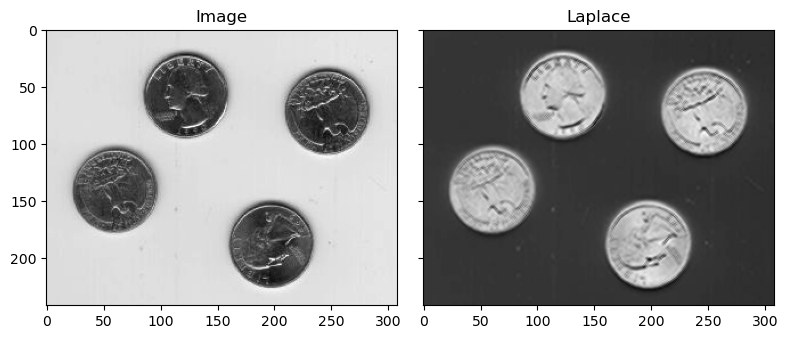

In [30]:
image = imread_gray('coins1.jpg')
lap = laplace(image, sigma=2.0)
plot_multiple([image, lap], ['Image', 'Laplace'])

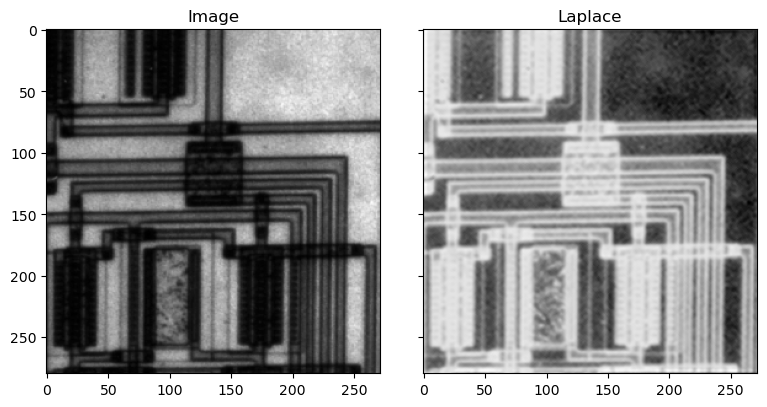

In [31]:
image = imread_gray('circuit.png')
lap = laplace(image, sigma=2.0)
plot_multiple([image, lap], ['Image', 'Laplace'])

# Edge Detection
In this part we will create a simple edge detector. 

**Note:** you will need `gauss_derivs` and `image_gradients_polar` functions from the task "Image derivatives". 

In [32]:
# Some convenience functions.

def convolve_with_two(image, kernel1, kernel2):
    """Apply two filters, one after the other."""
    image = ndimage.convolve(image, kernel1)
    image = ndimage.convolve(image, kernel2)   
    return image

def plot_multiple(images, titles, colormap='gray', max_columns=np.inf, imsize=4, share_axes=True):
    """Plot multiple images as subplots on a grid."""
    assert len(images) == len(titles)
    n_images = len(images)
    n_cols = min(max_columns, n_images)
    n_rows = int(np.ceil(n_images / n_cols))
    fig, axes = plt.subplots(
        n_rows, n_cols, figsize=(n_cols * imsize, n_rows * imsize),
        squeeze=False, sharex=share_axes, sharey=share_axes)

    axes = axes.flat
    # Hide subplots without content
    for ax in axes[n_images:]:
        ax.axis('off')
        
    if not isinstance(colormap, (list,tuple)):
        colormaps = [colormap]*n_images
    else:
        colormaps = colormap

    for ax, image, title, cmap in zip(axes, images, titles, colormaps):
        ax.imshow(image, cmap=cmap)
        ax.set_title(title)
        
    fig.tight_layout()

Write a function ``get_edges`` that returns a binary image ``edge`` from an input image where the color of each pixel $p$ is selected as follows (for a given threshold ``theta``):
\begin{eqnarray}
    p &=&
    \begin{cases}
        1, &\text{ if }\left|\operatorname{grad}(\mathtt{img})\right|(p) \geq \theta\\
        0, &\text{ else}
    \end{cases}
\end{eqnarray}
Experiment with the function ``get_edges`` on the example images.
Try to get good edge images for different values of ``sigma``.
What difficulties do you observe when selecting ``sigma`` and ``theta``?

In [33]:
# POINTS: 1

def get_edges(image, sigma, theta):
    # YOUR CODE HERE
    grad_img, _= image_gradients_polar(image,sigma)
    indexs1 = np.argwhere(grad_img >= theta)
    indexs0 = np.argwhere(grad_img < theta)

    edges = np.empty_like(image)
    
    for _,index in enumerate(indexs1):
        edges[index[0],index[1]] = grad_img[index[0],index[1]]
    for _,index in enumerate(indexs0):
        edges[index[0],index[1]] = 0
    return edges
    raise NotImplementedError()

C:\Users\Haoling Yang\AppData\Local\Temp\ipykernel_18920\1569066143.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  color_im = imageio.imread('gantrycrane.png')


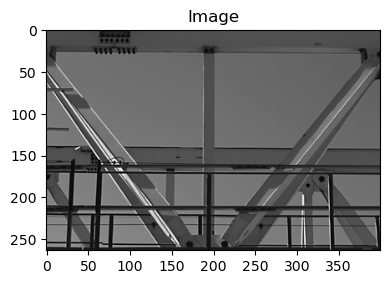

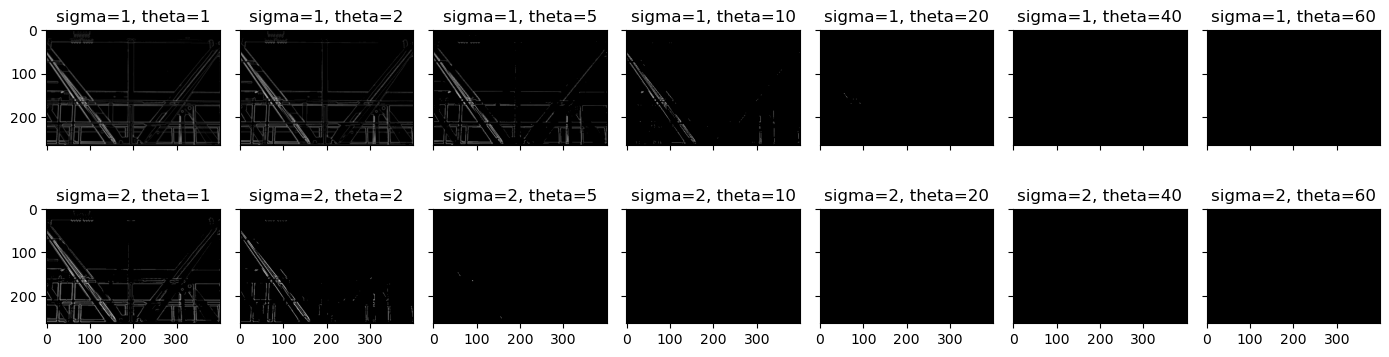

In [34]:
color_im = imageio.imread('gantrycrane.png')
gray_im = cv2.cvtColor(color_im, cv2.COLOR_RGB2GRAY).astype(np.float32)
plot_multiple([gray_im], ['Image'])

sigmas = [1, 2]
thetas = [1, 2, 5, 10, 20, 40, 60]

images = []
titles = []
for sigma in sigmas:
    for theta in thetas:
        edges = get_edges(gray_im, sigma, theta)    
        images.append(edges)
        titles.append(f'sigma={sigma}, theta={theta}')

plot_multiple(images, titles, max_columns=7, imsize=2)

Using the above function, returned edges are still several pixels wide.
In practice, this is often not desired.
Create a function ``get_edges_with_nms`` that extends ``get_edges`` by using the following function to suppress non-maximum points along the gradient direction.

Note that this simplified code does not interpolate between the neighboring pixel values in order to look up the real magnitude samples along the gradient direction.
This interpolation is crucial to obtain the necessary robustness for an actual implementation.
Here it was left out for better readability, since the interpolation involves some extra effort in order to deal with all special cases (e.g. exactly horizontal or vertical gradients).
If you feel motivated, you can try to add this step to make the function more robust.

In [35]:
# POINTS: 4

def nms_for_canny(grad_mag, grad_dir):
    result = np.zeros_like(grad_mag)

    # Pre-define pixel index offset along different orientation
    offsets_x = [-1, -1, 0, 1, 1, 1, 0, -1, -1]
    offsets_y = [0, -1, -1, -1, 0, 1, 1, 1, 0]
    height, width = grad_mag.shape
    for y in range(1, height - 1):
        for x in range(1, width - 1):
            # YOUR CODE HERE
            q = grad_mag[y,x]
            angle = (grad_dir[y, x]+np.pi)%np.pi
            if angle >= 0 and angle < np.pi/8:
                p = grad_mag[y,x+1]
                r = grad_mag[y,x-1]
            elif angle >= np.pi/8 and angle < 3*np.pi/8:
                p = grad_mag[y-1,x+1]
                r = grad_mag[y+1,x-1]
            elif angle >= 3*np.pi/8 and angle < 5*np.pi/8:
                p = grad_mag[y-1,x]
                r = grad_mag[y+1,x]
            elif angle >= 5*np.pi/8 and angle < 7*np.pi/8:
                p = grad_mag[y-1,x-1]
                r = grad_mag[y+1,x+1]
            else:
                p = grad_mag[y,x-1]
                r = grad_mag[y,x+1]
            
            if q > p and q > r:
                result[y,x] = grad_mag[y,x]
    return result
    raise NotImplementedError()


Another problem is that suitable values for ``theta`` may vary substantially between images.
Extend the function ``get_edges_with_nms`` such that the threshold $\theta \in [0,1]$ is defined relative to the maximal gradient magnitude value in the image.

In [36]:
# POINTS: 1

def get_edges_with_nms(image, sigma, theta):
    # YOUR CODE HERE
    grad_mag, grad_dir = image_gradients_polar(image,sigma)
    threshold = theta * np.max(grad_mag)
    edges = get_edges(image, sigma, threshold)
    return nms_for_canny(edges, grad_dir)
    raise NotImplementedError()

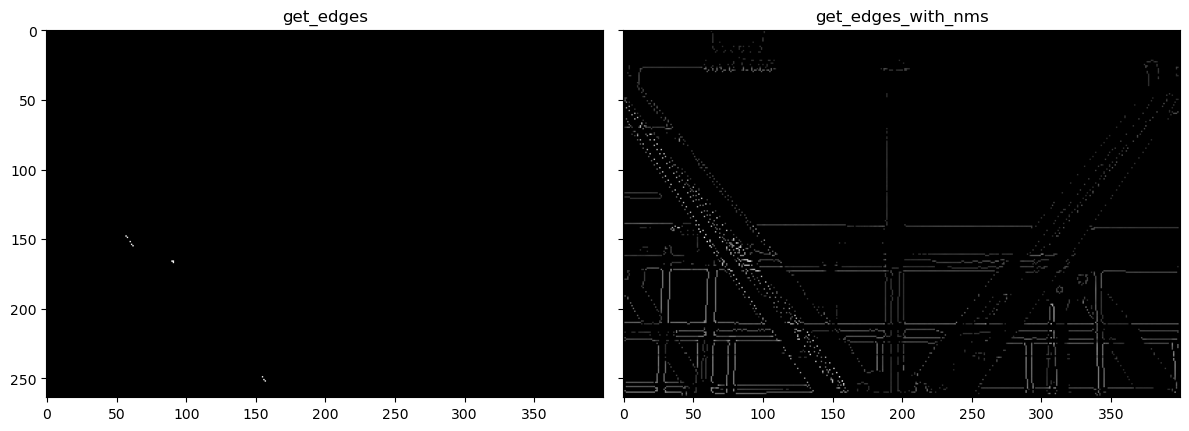

In [37]:
edges1 = get_edges(gray_im, sigma=2, theta=5)
edges2 = get_edges_with_nms(gray_im, sigma=2, theta=0.17) # 0.17 corresponds to an absolute threshold of 5

plot_multiple([edges1, edges2], ['get_edges', 'get_edges_with_nms'], imsize=6)

The function ``get_edges`` you implemented is a simplified version of the Canny edge detection pipeline.
The main step that is still missing is the edge following with hysteresis thresholding.
The idea here is that instead of applying a single threshold over the entire image, the edge detector works with two different thresholds ``theta_high`` and ``theta_low``.
It starts with an edge pixel with a value above ``theta_high`` and then follows the contour in the direction orthogonal to the gradient until the pixel value falls below ``theta_low``.
Each pixel visited along the way is labeled as an edge.
The procedure is repeated until no further pixel above ``theta_high`` remains.

Try writing a function ``my_canny`` that implements this procedure.
Don't worry about efficiency for the moment.
You may use the provided function skeleton to help you get started but can also start from scratch. The following hints may help you:
- You can create a boolean array ``visited`` for already visited and yet-to-visit image pixels. Since we are not interested in pixels below the low threshold you can mark them as visited. In another boolean array you can flag the pixels that serve as starting points for line following.
- You can also avoid having to deal with special cases along the image borders by creating a 1-pixel boundary where the ``visited`` flag is set to ``true``.
- The actual edge following part is most easily implemented as a recursive procedure. In most cases, you will have the option to choose between several possible continuation points. Again, the easiest way is to try all of them in sequence (or even all 8 neighbors) and let the recursive procedure (together with the ``visited`` flags) do the rest.

In [38]:
# POINTS: 5

def my_canny(image, sigma, theta_low, theta_high):
    # Compute gradient, apply non-maximum suppression
    # YOUR CODE HERE
    grad_mag, grad_dir = image_gradients_polar(image, sigma)
    grad_mag = nms_for_canny(grad_mag, grad_dir)
    #raise NotImplementedError()

    # Compute absolute threshold relative to max value
    max_val = np.max(grad_mag)
    theta_low_abs = theta_low * max_val
    theta_high_abs = theta_high * max_val

    # Initialize flags
    # Declare all pixels below the low threshold as visited
    # so edges are not followed there
    visited = grad_mag < theta_low_abs

    # Mark boundary pixels as visited
    visited[:, 0] = 1
    visited[:, -1] = 1
    visited[0, :] = 1
    visited[-1, :] = 1

    # Output image
    image_out = np.zeros_like(image)

    def follow_edge(x, y):
        visited[y, x] = True
        image_out[y, x] = 255

        # Pre-define pixel index offset along different orientation
        offsets_x = [-1, -1, 0, 1, 1, 1, 0, -1]
        offsets_y = [0, -1, -1, -1, 0, 1, 1, 1]

        for ox, oy in zip(offsets_x, offsets_y):
            # Note: `visited` is already False for points
            # below the low threshold.

            # YOUR CODE HERE
            if visited[y+oy, x+ox] == False and is_high[y+oy, x+ox] == False: #theta_high_abs>grad_mag>theta_low_abs, direction of gradient
                follow_edge(x+ox,y+oy)
            #raise NotImplementedError()

    is_high = grad_mag >= theta_high_abs
    # Main loop
    for x in range(image.shape[1]):
        for y in range(image.shape[0]):
            # YOUR CODE HERE
            if visited[y,x] == False and is_high[y, x] == True: #start with a value above theta_high and not visited
                follow_edge(x,y)
            #raise NotImplementedError()

    return image_out            

OpenCV provides a built-in function that implements the Canny edge detector.
https://docs.opencv.org/3.4/da/d5c/tutorial_canny_detector.html
Try ``cv2.Canny`` on the provided example images and compare the results to those of your implementation.
Note: the implementation of ``cv2.Canny`` does not include blurring the image as we did.
So apply ``cv2.GaussianBlur`` on the image, before passing it to ``cv2.Canny``.

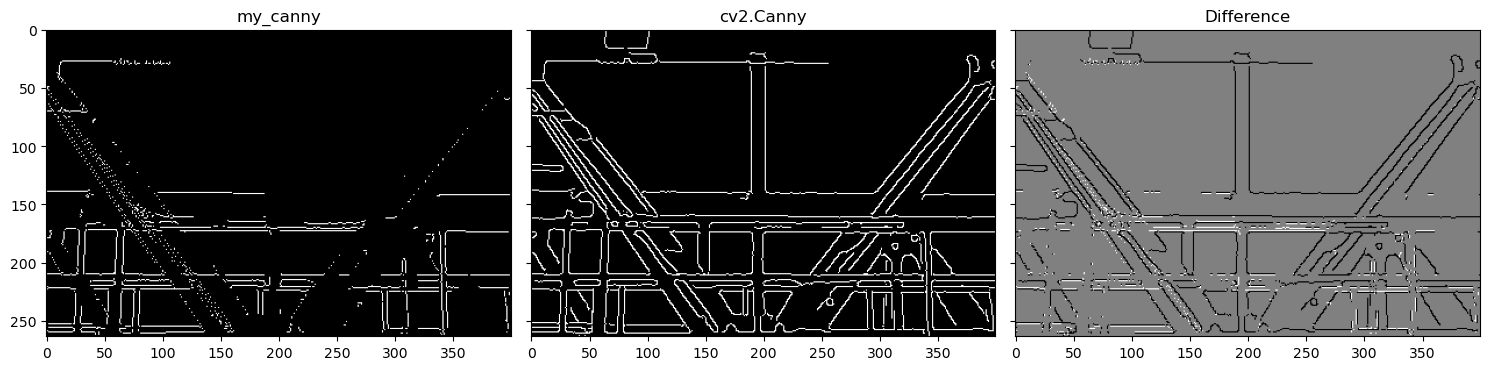

In [39]:
edge_canny = my_canny(gray_im, sigma=2, theta_low=0.1, theta_high=0.3)

blurred_cv = cv2.GaussianBlur(gray_im, ksize=(7,7), sigmaX=2)
edge_canny_cv = cv2.Canny(
    blurred_cv.astype(np.uint8), 
    39, 72, L2gradient=True).astype(np.float32)

plot_multiple([edge_canny, edge_canny_cv, edge_canny-edge_canny_cv], 
              ['my_canny', 'cv2.Canny', 'Difference'], imsize=5)